# Adversarial image synthesis using an MNIST classifier

This notebook utilizes the MNIST classifier of the previous tutorial.

**Learning goals:**
* Building and training a convolutional neural network on a bit lower level, mixing both Tensorflow and Keras, which allows us to perform more interesting manipulations.
* Cloning built models
* Synthesizing media as adversarial inputs to a classifier, in this case adversarial images.

**After you've read, run, and understood the code, try to modify it as follows to test your learning:**

*Note: we don't expect you to complete these all, we just provide many examples to illustrate that you can do quite many interesting things with a simple image classification network.*

* Easy: Instead of optimizing the classification loss, optimize an image that maximizes some individual neuron's output. Hint: you can access the neuron outputs as ```model2.layers[layer_index].output```
* Easy: Experiment with different starting images, and different network variations, e.g., amounts of drop-off. Also experiment in having the optimized image in a different resolution (you'll need to scale it for the network, though). Can you make more meaningful adversarial images emerge?
* Advanced: Develop a game where the player has to draw adversarial images that score high classification probabilities with as few pixels as possible. For this, you should either load the network to Unity using Tensorflow Sharp, or experiment with Python's mouse input etc. Obviously, such interaction is not possible inside Jupyter, so you should develop using some other IDE such as Visual Studio, Pycharm, or Spyder (the latter is included in Anaconda)
* Advanced: Track a user using Kinect, OpenPose or equivalent. Render the user's skeleton or silhouette as a Numpy tensor and make a game or interactive installation where the user attempts to pose such that he/she is recognized as a number by the MNIST classifier network.
* Advanced: Optimize the pose of an animated character such that the rendered silhouette makes the network think it's seeing numbers. You'll need to figure out a pipeline from an animation model to the silhouette rendered as a tensor that can be fed to the network. You can do the adversarial optimization either using a differentiable renderer like SoftRas as part of the compute graph and using a Tensorflow optimizer like Adam, or optimize the pose directly using CMA-ES or (LM-)MA-ES. We will talk about the latter two later on the course.

**Note that you can also try all of the above with audio**. You just need some audio dataset for training and Conv1D instead of Conv2D layers, as audio data is typically handled as 3D tensors of shape [nBatch,nAudioSamples,nChannels]

For more about mixing Keras and Tensorflow, see [https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html).

## Loading and visualizing the data

First, let's load the dataset using keras helpers and visualize some images using pyplot

c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.BNVRK7633HSX7YVO2TADGR4A5KEKXJAW.gfortran-win_amd64.dll
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


Populating the interactive namespace from numpy and matplotlib
shape:  (60000, 28, 28)
new shape:  (60000, 28, 28, 1)


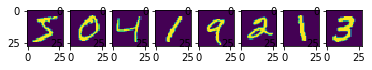

In [1]:
#The pylab inline below is something you may need to make images and plots visible in Jupyter, depending on your Anaconda setup
%pylab inline  
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, a simple example like this runs faster on CPU
import tensorflow as tf
import tensorflow.keras as keras
#from tensorflow import keras 

#load the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

#Scale the pixel intensity values to 0...1 from 0...255
#Fortunately, we don't a StandardScaler here
x_train, x_test = x_train / 255.0, x_test / 255.0

#check the shape: you should see that x_train is a 3D tensor, 
#with 60000 instances of 2D tensors 28x28 pixels 
print("shape: ",x_train.shape)

#because the keras layers we will use need explicitly defined pixel channel count as the fourth dimension,
#we reshape:
x_train=np.reshape(x_train,[x_train.shape[0],x_train.shape[1],x_train.shape[2],1])
print("new shape: ",x_train.shape)

#do the same for test data
x_test=np.reshape(x_test,[x_test.shape[0],x_test.shape[1],x_test.shape[2],1])


#visualize some of the images
pp.figure(1)
for i in range(8):
    pp.subplot(1,8,1+i)
    #imshow expects a 2d tensor, thus we pick the i:th image, full width and height, and the first and only color channel
    pp.imshow(x_train[i,:,:,0])


## Going more low-level with Keras and Tensorflow 

Keras models like the one used in the previous exercise are pretty much black boxes. If you want to hack together something more sophisticated, you'll often have to open the box a little. Below, we implement the following modifications:
* We define the network's input explicitly as a placeholder tensor. This allows us to replace it with a variable that can be optimized for adversarial image generation.
* We define the layers as above, but explicitly add an input layer
* Instead of using model.compile() and model.fit(), we explicitly define the loss function and use a Tensorflow optimizer. This is now required as we have the explicit input layer. 
* We use another optimizer for adversarial image generation.

*Pay particular attention to how one uses sess.run() to interact with the compute graph.*

In [10]:
#In addition to the layers used before, we will need InputLayer, 
#which allows us to explicitly define the tensors that the network receives as inputs
from tensorflow.keras.layers import Dense   #fully connected layer
from tensorflow.keras.layers import Conv2D  #convolutional layer with 2D filters (for audio you would use 1D)
from tensorflow.keras.layers import Flatten #converts images to plain vectors of numbers
from tensorflow.keras.layers import Dropout #this mitigates overfitting
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Activation

#When coding with "raw" tensorflow, one always needs a session variable. 
#We also reset the default graph which prevents things from slowing down if you run this Jupyter cell multiple times.
#Otherwise, you would end up creating many redundant copies of the network.
tf.reset_default_graph()
sess=tf.InteractiveSession()

#declare input placeholders to which to upload data
nClasses=10
tfX=tf.placeholder(dtype=tf.float32,shape=[None,28,28,1]);
tfY=tf.placeholder(dtype=tf.int32,shape=[None]);

#Build model the model. The difference to the previous tutorial is that we add the InputLayer.
model = keras.models.Sequential()
model.add(InputLayer(input_tensor=tfX,input_shape=(28,28,1,)))
model.add(Conv2D(16, kernel_size=(5, 5), strides=[2,2],activation='relu'))
model.add(Conv2D(32, (5, 5), activation='relu', strides=[2,2]))
model.add(Conv2D(32, (3, 3), activation='relu', strides=[2,2]))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation(activation='softmax'))
output=model.output 

#With the input tensor defined, we can't anymore use model.compile() and model.fit(), as we must explicitly handle
#the minibatches that go into the network. Thus, let's define the training loss and optimizer
loss=tf.losses.sparse_softmax_cross_entropy(tfY,output)
optimizer=tf.train.AdamOptimizer()

#optimizer.minimize() gives us a special tensor. Optimization iterations are triggered when we fetch this tensor using sess.run()
optimize=optimizer.minimize(loss)

#initialize variables (another thing one needs to do when coding low-level)
tf.global_variables_initializer().run(session=sess)

#Optimize
nIter=5000
for iter in range(nIter):
    #Extract a random minibatch from the data
    nMinibatch=32
    batchIndices=np.random.randint(0,x_train.shape[0],[nMinibatch])
    batch_x,batch_y=x_train[batchIndices],y_train[batchIndices]
    
    #Use sess.run() to perform the optimization iterations.
    #sess.run() is the main method for interacting with the compute graph: you fetch a number of tensors,
    #and you pass in all inputs that the fetches require. Before a sess.run() call, there's no computation
    #happening, and the code above just constructs the graph. This is a big conceptual difference to simply
    #programming with numpy, where function calls directly modify tensor contents. 
    
    #Furthermore, the tensors that one fetches may trigger all kinds of computations, e.g., the optimizer.
    
    #Here, the optimization and the loss function computing needs data for the tfX and tfY placeholder tensors.
    #To make the Keras Dropout layers work, we also must pass in the learning_phase boolean
    [temp,currLoss]=sess.run(fetches=[optimize,loss],feed_dict={
        tfX:x_train[batchIndices],
        tfY:y_train[batchIndices],
        tf.keras.backend.learning_phase():True})
    
    #print progress every 100 iterations
    if iter%100==0:
        print("Iteration {}/{}, Loss {}".format(iter,nIter,currLoss))


c:\CondaEnvs\tensorflow2\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Iteration 0/5000, Loss 2.3023393154144287
Iteration 100/5000, Loss 1.7727928161621094
Iteration 200/5000, Loss 1.6965547800064087
Iteration 300/5000, Loss 1.719458818435669
Iteration 400/5000, Loss 1.7168712615966797
Iteration 500/5000, Loss 1.7102552652359009
Iteration 600/5000, Loss 1.6191222667694092
Iteration 700/5000, Loss 1.7159738540649414
Iteration 800/5000, Loss 1.6502971649169922
Iteration 900/5000, Loss 1.5228047370910645
Iteration 1000/5000, Loss 1.809114694595337
Iteration 1100/5000, Loss 1.6790337562561035
Iteration 1200/5000, Loss 1.6468656063079834
Iteration 1300/5000, Loss 1.7037944793701172
Iteration 1400/5000, Loss 1.5905561447143555
Iteration 1500/5000, Loss 1.630395770072937
Iteration 1600/5000, Loss 1.6414005756378174
Iteration 1700/5000, Loss 1.678420066833496
Iteration 1800/5000, Loss 1.6300463676452637
Iteration 1900/5000, Loss 1.5967791080474854
Iteration 2000/5000, Loss 1.6446833610534668
Iteration 2100/5000, Loss 1.6511421203613281
Iteration 2200/5000, Loss 

Same as before, let's test the classifier with an image.

Testing with image:


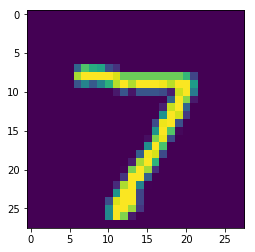

Predicted class probabilities:  [[1.5943519e-18 3.8778893e-12 1.6141200e-12 1.2608499e-09 8.8223233e-13
  9.6200293e-15 2.5357936e-17 1.0000000e+00 2.1214092e-12 4.6829155e-18]]
The most probable class is 7, with probability 1.0


In [11]:
#this is the test image
testIdx=0
#Show the image
print("Testing with image:")
pp.imshow(x_test[testIdx,:,:,0])
pp.show()
#We index by testIdx:testIdx+1 to pass a batch of one image to the network instead of just one image
classProbabilities=sess.run(output,{tfX:x_test[testIdx:testIdx+1]})
print("Predicted class probabilities: ",classProbabilities)
#np.argmax returns the index of the largest value in a Numpy tensor.
#np.max returns the largest value
print("The most probable class is {}, with probability {}".format(np.argmax(classProbabilities),np.max(classProbabilities)))


## Adversarial image generation

Finally, to be able to optimize the adversarial images, we make a new copy of the network, but such that this one receives a tf.Variable() as its inputs. We can then optimize the variable just like we earlier optimized the network parameters. 

This illustrates the power of Tensorflow and other modern compute graph platforms: Anything can be optimized with respect to anything else, as long as the compute graph contains only differentiable operations.


In [12]:
#We define a variable of shape [1,28,28,1], i.e., a batch of a single image
#Variables are special tensors that contain optimized parameters or other data
#that one wants to store persistently.
image=tf.Variable(dtype=tf.float32,initial_value=np.random.uniform(0,1,[1,28,28,1]))

#Make a copy of the trained network but with new inputs
model2=tf.keras.models.clone_model(model,image)

#Copy weights
model2.set_weights(model.get_weights())


Just to make sure the copying was successful, test the cloned model with the an image.

**NOTE:** as the network's input is the variable, we don't feed the image as a parameter to sess.run()
Instead, we load the image to the variable before calling sess.run()

Testing cloned model with image:


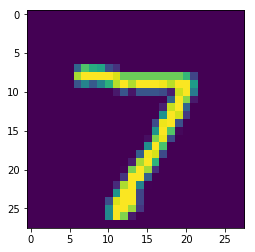

Predicted class probabilities:  [[1.5943519e-18 3.8778893e-12 1.6141200e-12 1.2608499e-09 8.8223233e-13
  9.6200293e-15 2.5357936e-17 1.0000000e+00 2.1214092e-12 4.6829155e-18]]
The most probable class is 7, with probability 1.0


In [13]:
testIdx=0
print("Testing cloned model with image:")
pp.imshow(x_test[testIdx,:,:,0])
pp.show()
image.load(np.reshape(x_test[testIdx],[1,28,28,1]))
classProbabilities=sess.run(model2.output)
print("Predicted class probabilities: ",classProbabilities)
print("The most probable class is {}, with probability {}".format(np.argmax(classProbabilities),np.max(classProbabilities)))


Now we can start optimize the image until it gives some other class output.

Iteration 0/10000, Loss 2.4597318172454834, Target class probability 1.0004727073464892e-06
Iteration 1000/10000, Loss 2.4051501750946045, Target class probability 0.0007444066577591002
Iteration 2000/10000, Loss 1.4611523151397705, Target class probability 0.9999973773956299
Iteration 3000/10000, Loss 1.461152195930481, Target class probability 0.999997615814209
Iteration 4000/10000, Loss 1.461152195930481, Target class probability 0.9999978542327881
Iteration 5000/10000, Loss 1.4611517190933228, Target class probability 0.9999982118606567
Iteration 6000/10000, Loss 1.461151361465454, Target class probability 0.9999985694885254
Iteration 7000/10000, Loss 1.4611510038375854, Target class probability 0.999998927116394
Iteration 8000/10000, Loss 1.4611510038375854, Target class probability 0.9999991655349731
Iteration 9000/10000, Loss 1.4611506462097168, Target class probability 0.9999995231628418
Iteration 10000/10000, Loss 1.4611505270004272, Target class probability 0.9999997615814209

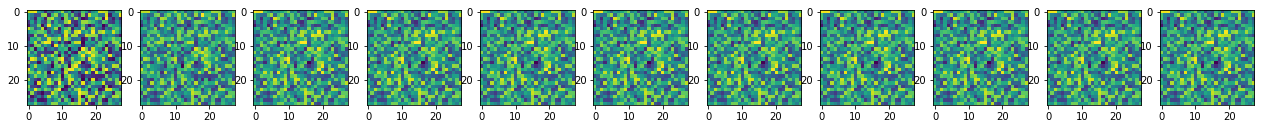

In [41]:
#We want the image to represent this class.
targetClass=0

#Now, we again need the classification loss, i.e., categorical cross-entropy.
#For the loss function, we need to wrap the targetClass variable inside a Tensorflow constant tensor
loss=tf.losses.sparse_softmax_cross_entropy(tf.constant([[targetClass]],dtype=int32),model2.output)

#For debug, extract the target class probability
targetClassProbability=model2.output[0,targetClass]

#Create the optimization operation. We explicitly define that we want to only optimize the image,
#because otherwise the network's parameters would get changed too.
optimizeAdversarial=tf.train.AdamOptimizer().minimize(loss,var_list=[image])

#Now a bit of a kludge: because we created a new optimizer, we must run 
#the Tensorflow global variables initializer again, and this will re-randomize our model weights.
#Thus, we first save the weights and then reload them after running the initializer
weights=model2.get_weights()
tf.global_variables_initializer().run(session=sess)
model2.set_weights(weights)

#This is our initial image
image.load(np.random.uniform(0,1,[1,28,28,1]),sess) 

#Optimize
nIter=10000
images=[]  #we will store intermediate results here
for iter in range(nIter+1):
    #here, sess.run() is simple, as we don't have to feed any placeholders
    [temp,currLoss,currProb]=sess.run(fetches=[optimizeAdversarial,loss,targetClassProbability])
    #print and show progress
    if iter%1000==0:
        #print current target class probability
        print("Iteration {}/{}, Loss {}, Target class probability {}".format(iter,nIter,currLoss,currProb))
        #fetch and store the current image
        images.append(sess.run(image)[0,:,:,0])

#Display the images        
nImages=len(images)
pp.figure(1,figsize(nImages*2,2))
for i in range(nImages):
    pp.subplot(1,nImages,1+i)
    pp.imshow(images[i])

